In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/DL Proj

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/.shortcut-targets-by-id/1YVeuUAzHoGzUPlo7fMNjd5OVIsSLwMFE/DL Proj


In [ ]:
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
!pip install torch torchvision
!pip install pyyaml==5.1 pycocotools>=2.0.1 matplotlib opencv-python-headless tqdm
!git clone https://github.com/ultralytics/yolov5.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
Cloning into 'yolov5'...
remote: Enumerating objects: 15639, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 15639 (delta 120), reused 141 (delta 68), pack-reused 15393
Receiving objects: 100% (15639/15639), 14.59 MiB | 8.34 MiB/s, done.
Resolving deltas: 100% (10649/10649), done.
Updating files: 100% (142/142), done.


--2023-05-02 14:15:58--  https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.59, 13.227.219.10, 13.227.219.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177841981 (170M) [application/octet-stream]
Saving to: ‘Accurate-Interpretable-VAD/pre_processing/checkpoints/model_final_f10217.pkl’

model_final_f10217. 100%[===================>] 169.60M  60.1MB/s    in 2.8s    

2023-05-02 14:16:01 (60.1 MB/s) - ‘Accurate-Interpretable-VAD/pre_processing/checkpoints/model_final_f10217.pkl’ saved [177841981/177841981]



In [ ]:
# !python Accurate-Interpretable-VAD/pre_processing/bboxes.py [--dataset_name] [Optional: --train] 
# !python Accurate-Interpretable-VAD/pre_processing/bboxes.py --dataset_name=ped2 --train 


In [ ]:
import torch
import torchvision
import cv2
from PIL import Image
import numpy as np
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import argparse
from tqdm import tqdm

In [ ]:
# Define the device for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Load the pretrained ResNet50 model
# model = torchvision.models.resnet50(pretrained=True).to(device)
# model.eval()

# backbone = torchvision.models.resnet50_fpn(pretrained=True)

# model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


AttributeError: ignored

In [ ]:
# print(image_tensor.shape)


# faster rcnn

In [ ]:
import torch
import torchvision
import torchvision.models.detection as detection
from torchvision.models.resnet import Bottleneck
from torchvision.ops.feature_pyramid_network import LastLevelP6P7, FeaturePyramidNetwork

# Define a ResNeSt Bottleneck block
class ResNeStBottleneck(Bottleneck):
    expansion = 4
    def __init__(self, *args, **kwargs):
        super(ResNeStBottleneck, self).__init__(*args, **kwargs)

# Define a ResNeSt-50 FPN backbone
class ResNeStFPN(torch.nn.Module):
    def __init__(self):
        super(ResNeStFPN, self).__init__()
        # Load the ResNeSt-50 backbone
        resnest = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        # Replace the stem layer
        self.stem = torch.nn.Sequential(
            resnest.conv1,
            resnest.bn1,
            resnest.relu,
            resnest.maxpool,
        )
        # Replace the ResNet-50 blocks with ResNeSt-50 blocks
        self.layer1 = torch.nn.Sequential(
            ResNeStBottleneck(256, 64, resnest.layers[0], 1),
            *list(resnest.layers[1:])
        )
        # Construct the FPN using the ResNet blocks and the LastLevelP6P7 module
        self.top_blocks = LastLevelP6P7(2048, 256)
        self.fpn = FeaturePyramidNetwork([256, 512, 1024, 2048], 256, extra_blocks=self.top_blocks)

    def forward(self, x):
        # Forward through the stem
        x = self.stem(x)
        # Forward through the ResNeSt blocks
        x = self.layer1(x)
        # Forward through the FPN
        features = self.fpn(x)
        return features

# Create a ResNeSt-50 FPN backbone
backbone = ResNeStFPN()

In [ ]:
# Replace the classification and box regression heads with new ones
num_classes = 91  # COCO dataset has 80 classes
model = detection.fasterrcnn_resnet50_fpn(num_classes=num_classes, pretrained_backbone=False, backbone=backbone)

# Load the pre-trained weights
state_dict = torch.hub.load_state_dict_from_url('https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth')
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

backbone.roi_heads.box_predictor.cls_score = torch.nn.Linear(1024, num_classes)
backbone.roi_heads.box_predictor.bbox_pred = torch.nn.Linear(1024, num_classes * 4)

# Load the COCO object detection labels
with open('coco_labels.txt', 'r') as f:
    labels = [line.strip() for line in f]

# Load an image
path ='UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/Train006/001.tif'
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to a PyTorch tensor
image_tensor = torchvision.transforms.functional.to_tensor(image)

# Add a batch dimension to the tensor
image_tensor = image_tensor.unsqueeze(0)

# Run the backbone on the image tensor to get feature maps
features = backbone(image_tensor)

# Get the proposals and box classifications/regressions from the backbone
proposals = features['0']
class_logits, box_regression = features['1'], features['2']

# Create a Faster R-CNN detector using the proposals, class logits, and box regression
detector = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
detector.roi_heads.box_predictor.cls_score = backbone.roi_heads.box_predictor.cls_score
detector.roi_heads.box_predictor.bbox_pred = backbone.roi_heads.box_predictor.bbox_pred

# Construct the prediction object from the proposals, class logits, and box regression
predictions = detector.roi_heads.box_predictor(class_logits, box_regression, proposals)

# Apply non-maximum suppression to get the final predictions
threshold = 0.5
keep = torchvision.ops.nms(predictions['boxes'], predictions['scores'], threshold)
predictions = {k: v[keep] for k, v in predictions.items()}

# Extract the bounding boxes, labels, and scores from the predictions
boxes = predictions['boxes'].detach().cpu().numpy()
labels = predictions['labels'].detach().cpu().numpy()
scores = predictions['scores'].detach().cpu().numpy()

ImportError: ignored

In [ ]:
# Convert the image back to BGR format for OpenCV display
image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
# Load the original image
# img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

# for box, label in zip(boxes, labels):
#     x1, y1, x2, y2 = box[:4]  # Unpack the first four values only
#     cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
#     cv2.putText(img, model.names[int(label)], (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Draw the bounding boxes on the image
for box, label, score in zip(boxes, labels, scores):
    x1, y1, x2, y2 = box.astype(int)
    cv2.rectangle(image_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
    label_text = f'{labels[int(label)]} ({score:.2f})'
    cv2.putText(image_bgr, label_text, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image
cv2_imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
cv2.waitKey(0)
cv2.destroyAllWindows()

# resnet50

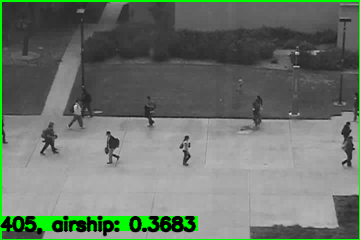

In [ ]:
# labels_path = 'imagenet_classes.txt'
# with open(labels_path) as f:
#     labels = [line.strip() for line in f.readlines()]

# # Load the image and convert it to RGB format
# path ='UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/Train006/001.tif'
# image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
# image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

# # Define the image transformation
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

# # Apply the image transformation
# image_tensor = transform(image)

# # Add an extra dimension to the tensor to create a batch of size 1
# image_tensor = image_tensor.unsqueeze(0)

# # Pass the image through the model
# output = model(image_tensor)

# # Get the class probabilities and corresponding class indices
# probs, indices = torch.topk(torch.softmax(output, dim=1), k=1)

# # Get the predicted class index and probability
# class_idx = indices[0][0].item()
# class_prob = probs[0][0].item()

# # Get the predicted class label
# class_label = labels[class_idx]

# # Get the size of the image
# height, width, _ = image.shape

# # Get the predicted bounding box coordinates
# xmin, ymin, xmax, ymax = 0, 0, width, height

# Yolo

In [ ]:
###model is Yolo
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
path ='UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train/Train006/001.tif'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = Image.fromarray(img)
results = model(img)
# Get bounding boxes and class labels
boxes = results.xyxy[0].numpy()
labels = results.xyxy[0][:, -1].numpy()

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-2 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 


requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


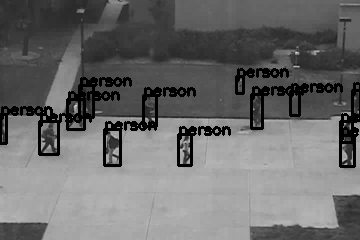

In [ ]:
# # Load the original image
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

for box, label in zip(boxes, labels):
    x1, y1, x2, y2 = box[:4]  # Unpack the first four values only
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
    cv2.putText(img, model.names[int(label)], (int(x1), int(y1)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Display the image
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Final

In [ ]:
confidence_threshold = 0.5
min_area = 10 * 10,
cover_threshold = 0.6, 
binary_threshold = 18,
gauss_mask_size = 3, 
contour_min_area = 10 * 10


def get_objects_bboxes(path, model, min_area):
    """
    Returns bboxes of given image.
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = Image.fromarray(img)
    results = model(img)
    # Get bounding boxes and class labels
    boxes = results.xyxy[0].detach().cpu().numpy()
    classes = results.xyxy[0][:, -1].detach().cpu().numpy()

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    bbox_areas = (y2 - y1 + 1) * (x2 - x1 + 1)
    return boxes[bbox_areas >= min_area], bbox_areas[bbox_areas >= min_area], classes[bbox_areas >= min_area]

def delete_overlapped_bboxes(bboxes, bbox_areas, cover_threshold, classes):
    """
    Removes bboxes which overlaps which other bbox.
    """
    assert bboxes.ndim == 2
    assert bboxes.shape[1] == 4

    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    sort_idx = bbox_areas.argsort()  # Index of bboxes sorted in ascending order by area size

    keep_idx = []
    for i in range(sort_idx.size):  # calculate overlap with i-th bbox
        # Calculate the point coordinates of the intersection
        x11 = np.maximum(x1[sort_idx[i]], x1[sort_idx[i + 1:]])
        y11 = np.maximum(y1[sort_idx[i]], y1[sort_idx[i + 1:]])
        x22 = np.minimum(x2[sort_idx[i]], x2[sort_idx[i + 1:]])
        y22 = np.minimum(y2[sort_idx[i]], y2[sort_idx[i + 1:]])
        # Calculate the intersection area
        w = np.maximum(0, x22 - x11 + 1)
        h = np.maximum(0, y22 - y11 + 1)
        overlaps = w * h

        ratios = overlaps / bbox_areas[sort_idx[i]]
        num = ratios[ratios > cover_threshold]
        if num.size == 0:
            keep_idx.append(sort_idx[i])
    return bboxes[keep_idx], classes[keep_idx]

def get_foreground_bboxes(img_batch, bboxes, area_threshold, binary_threshold, gauss_mask_size):
    extend = 2
    sum_grad = 0

    img1 = cv2.GaussianBlur(img_batch[0], (gauss_mask_size, gauss_mask_size), 0)
    img2 = cv2.GaussianBlur(img_batch[1], (gauss_mask_size, gauss_mask_size), 0)
    grad = cv2.absdiff(img1, img2)
    sum_grad = grad + sum_grad
    sum_grad = cv2.threshold(sum_grad, binary_threshold, 255, cv2.THRESH_BINARY)[1]  # temporal gradient

    for bbox in bboxes:
        bbox_int = bbox.astype(np.int32)
        extend_y1 = np.maximum(0, bbox_int[1] - extend)
        extend_y2 = np.minimum(bbox_int[3] + extend, sum_grad.shape[0])
        extend_x1 = np.maximum(0, bbox_int[0] - extend)
        extend_x2 = np.minimum(bbox_int[2] + extend, sum_grad.shape[1])
        sum_grad[extend_y1:extend_y2 + 1, extend_x1:extend_x2 + 1] = 0
        
    sum_grad = cv2.cvtColor(sum_grad, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(sum_grad, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        sum_grad = cv2.rectangle(sum_grad, (x, y), (x + w, y + h), color=255, thickness=1)
        area = (w + 1) * (h + 1)
        if area > area_threshold and w / h < 10 and h / w < 10:
            extend_x1 = np.maximum(0, x - extend)
            extend_y1 = np.maximum(0, y - extend)
            extend_x2 = np.minimum(x + w + extend, sum_grad.shape[1])
            extend_y2 = np.minimum(y + h + extend, sum_grad.shape[0])
            final_bboxes.append([extend_x1, extend_y1, extend_x2, extend_y2])

    return np.array(final_bboxes)


def extract(dataset_root, dataset_name, train):
    dataset = VideoDataset(dataset_name=dataset_name, root=dataset_root, train=train, sequence_length=1,
                           bboxes_extractions=True)
    MIN_AREA = min_area
    COVER_THRESHOLD = cover_threshold
    area_threshold = contour_min_area
    binary_threshold = binary_threshold
    gauss_mask_size = gauss_mask_size
    confidence_threshold = confidence_threshold
    predictor = Predictor(confidence_threshold=confidence_threshold)
    all_bboxes = []
    all_classes = []
    for idx in tqdm(range(len(dataset)), total=len(dataset)):
        batch, _ = dataset.__getitem__(idx)
        # main frame
        cur_img = img_tensor2numpy(batch[1])
        obj_bboxes, bbox_areas, classes = get_objects_bboxes(cur_img, predictor, MIN_AREA, dataset_name)

        # filter some overlapped bbox
        obj_bboxes_after_overlap_removal, classes_after_removal = delete_overlapped_bboxes(obj_bboxes, bbox_areas, COVER_THRESHOLD, classes)

        foreground_bboxes = get_foreground_bboxes(img_batch_tensor2numpy(batch), obj_bboxes_after_overlap_removal,
                                                  area_threshold, binary_threshold, gauss_mask_size)
        if foreground_bboxes.shape[0] > 0:
            cur_bboxes = np.concatenate((obj_bboxes_after_overlap_removal, foreground_bboxes), axis=0)
            cur_classes = np.concatenate((classes_after_removal, (np.zeros(len(foreground_bboxes)))), axis=0)
        else:
            cur_bboxes = obj_bboxes_after_overlap_removal
            cur_classes = classes_after_removal
        all_bboxes.append(cur_bboxes)
        all_classes.append(cur_classes)

    if train:
        np.save(os.path.join(os.path.join(dataset_root, dataset_name),
                             '%s_bboxes_train.npy' % dataset_name), all_bboxes)
        np.save(os.path.join(os.path.join(dataset_root, dataset_name),
                             '%s_bboxes_train_classes.npy' % dataset_name), all_classes)
    else:
        np.save(os.path.join(os.path.join(dataset_root, dataset_name),
                             '%s_bboxes_test.npy' % dataset_name), all_bboxes)
        np.save(os.path.join(os.path.join(dataset_root, dataset_name),
                             '%s_bboxes_test_classes.npy' % dataset_name), all_classes)
    print('bboxes saved!')


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--dataset_name", type=str, default="ped2", help='dataset name')
    parser.add_argument("--train", action='store_true', help='train or test data')
    args = parser.parse_args()
    root = 'data/'
    extract(dataset_root=root, dataset_name=args.dataset_name, train=args.train)

usage: ipykernel_launcher.py [-h] [--dataset_name DATASET_NAME] [--train]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-8604f047-a8f6-4e07-9219-cd9911579754.json


SystemExit: ignored